In [14]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

Классификация
==========
Классификация – отнесение объекта к одной из категорий на основании его признаков.

* https://habrahabr.ru/company/ods/blog/328372/
* http://contrib.scikit-learn.org/imbalanced-learn/stable/
* https://habrahabr.ru/company/ods/blog/323890/#lineynyy-klassifikator
* https://www.kaggle.com/wiki/Metrics
* https://habrahabr.ru/company/io/blog/265007/
* https://habrahabr.ru/post/105220/

## Метрики качества классификаторов

### Матрица ошибок (Confusion matrix)
Матрица ошибок — это способ разбить объекты на четыре категории в зависимости от комбинации истинного ответа и ответа алгоритма.

Основные термины:
* $TP$ — истино-положительное решение;
* $TN$ — истино-отрицательное решение;
* $FP$ — ложно-положительное решение (Ошибка первого рода);
* $FN$ — ложно-отрицательное решение (Ошибка второго рода).

![](img/confusion_matrix.png)

<a href="img/DiagnosticTesting_Diagram.svg" target="_blank">Интерактивная картинка с большим числом метрик</a>


Accuracy — доля правильных ответов:

$${\displaystyle \mathrm {Accuracy} ={\frac {\mathrm {TP} +\mathrm {TN} }{P+N}}={\frac {\mathrm {TP} +\mathrm {TN} }{\mathrm {TP} +\mathrm {TN} +\mathrm {FP} +\mathrm {FN} }}}$$

Данная матрика имеет существенный недостаток — её значение необходимо оценивать в контексте баланса классов. Eсли в выборке 950 отрицательных и 50 положительных объектов, то при абсолютно случайной классификации мы получим долю правильных ответов 0.95. Это означает, что доля положительных ответов сама по себе не несет никакой информации о качестве работы алгоритма a(x), и вместе с ней следует анализировать соотношение классов в выборке.

Гораздо более информативными критериями являются [точность (precision) и полнота (recall)](https://en.wikipedia.org/wiki/Precision_and_recall).

Точность показывает, какая доля объектов, выделенных классификатором как положительные, действительно является положительными:
$$Precision = \frac{TP}{TP+FP}$$

Полнота показывает, какая часть положительных объектов была выделена классификатором:
$$Recall = \frac{TP}{TP+FN}$$
<img src="img/precisionrecall.png" width="300">

Существует несколько способов получить один критерий качества на основе точности и полноты. Один из них — F-мера, гармоническое среднее точности и полноты:
$$
F_\beta = (1 + \beta^2) \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}{(\beta^2 \cdot \mathrm{precision}) + \mathrm{recall}} = \frac {(1 + \beta^2) \cdot \mathrm{true\ positive} }{(1 + \beta^2) \cdot \mathrm{true\ positive} + \beta^2 \cdot \mathrm{false\ negative} + \mathrm{false\ positive}}$$

Среднее гармоническое обладает важным свойством — оно близко к нулю, если хотя бы один из аргументов близок к нулю. Именно поэтому оно является более предпочтительным, чем среднее арифметическое (если алгоритм будет относить все объекты к положительному классу, то он будет иметь recall = 1 и precision больше 0, а их среднее арифметическое будет больше 1/2, что недопустимо).

Чаще всего берут $\beta=1$, хотя иногда встречаются и другие модификации. $F_2$ острее реагирует на recall (т. е. на долю ложноположительных ответов), а $F_{0.5}$ чувствительнее к точности (ослабляет влияние ложноположительных ответов).

В sklearn есть удобная функция [sklearn.metrics.classification_report](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html), возвращающая recall, precision и F-меру для каждого из классов, а также количество экземпляров каждого класса.

In [9]:
from sklearn.metrics import classification_report
y_true = [0, 1, 2, 2, 2]
y_pred = [0, 0, 2, 2, 1]
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_true, y_pred, target_names=target_names))

             precision    recall  f1-score   support

    class 0       0.50      1.00      0.67         1
    class 1       0.00      0.00      0.00         1
    class 2       1.00      0.67      0.80         3

avg / total       0.70      0.60      0.61         5



## Линейная классификация
Основная идея линейного классификатора заключается в том, что признаковое пространство может быть разделено гиперплоскостью на две полуплоскости, в каждой из которых прогнозируется одно из двух значений целевого класса.
Если это можно сделать без ошибок, то обучающая выборка называется линейно разделимой.
![](https://habrastorage.org/files/77b/af8/55c/77baf855c84a4ba9a851060ec7ae6ec8.png)

Указанная разделяющая плоскость называется линейным дискриминантом.



### Логистическая регрессия
Логистическая регрессия является частным случаем линейного классификатора, но она обладает хорошим "умением" – прогнозировать вероятность отнесения наблюдения к классу. Таким образом, результат логистической регрессии всегда находится в интервале [0, 1].

https://en.wikipedia.org/wiki/Iris_flower_data_set

[iris.csv](https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv)

In [4]:
iris = pd.read_csv("iris.csv")

In [5]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [6]:
iris.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


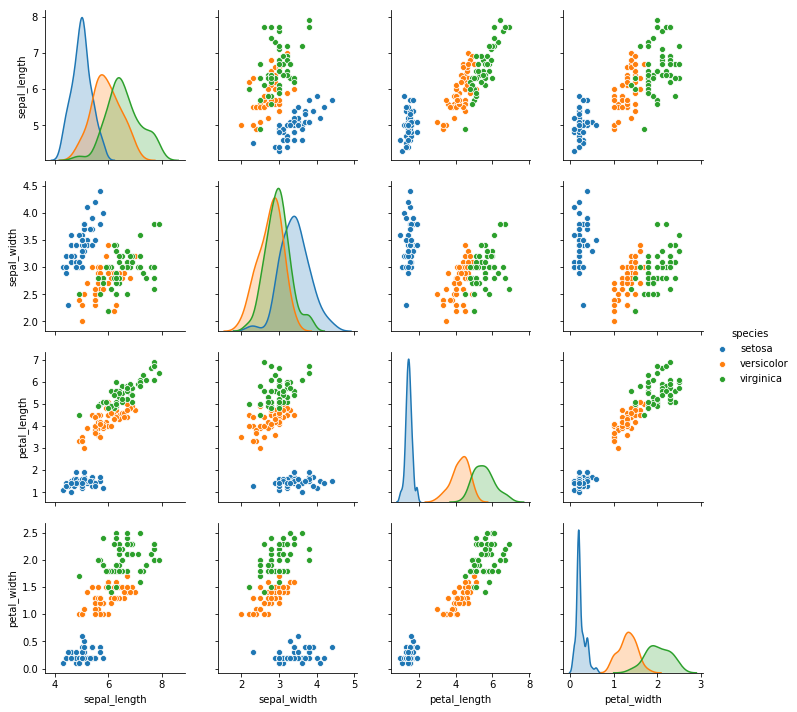

In [10]:
sns.pairplot(iris, hue="species")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


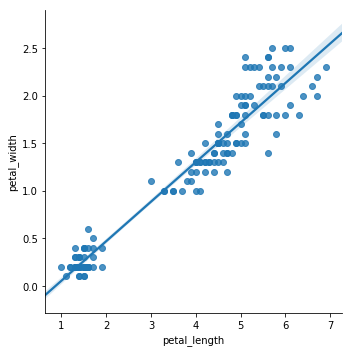

In [11]:
sns.lmplot(x="petal_length", y="petal_width", data=iris)

In [54]:
X = iris.iloc[:, 2:4].values
y = iris['species'].values

In [17]:
y[:5]

array(['setosa', 'setosa', 'setosa', 'setosa', 'setosa'], dtype=object)

In [55]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y)
y = le.transform(y)
y[:5]

array([0, 0, 0, 0, 0])

In [57]:
iris_pred_names = le.classes_
iris_pred_names

array(['setosa', 'versicolor', 'virginica'], dtype=object)

In [58]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

In [59]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [60]:
X_train[:5], X_train_std[:5]

(array([[3.5, 1. ],
        [5.5, 1.8],
        [5.7, 2.5],
        [5. , 1.5],
        [5.8, 1.8]]), array([[-0.18295039, -0.29318114],
        [ 0.93066067,  0.7372463 ],
        [ 1.04202177,  1.63887031],
        [ 0.6522579 ,  0.35083601],
        [ 1.09770233,  0.7372463 ]]))

In [61]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=100.0, random_state=1)
lr.fit(X_train_std, y_train)

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [62]:
lr.predict_proba(X_test_std[:3, :])

array([[2.77475804e-08, 6.31730607e-02, 9.36826912e-01],
       [7.87476628e-03, 9.91707489e-01, 4.17744834e-04],
       [8.15542033e-01, 1.84457967e-01, 8.14812482e-12]])

In [63]:
lr.predict_proba(X_test_std[:3, :]).sum(axis=1)

array([1., 1., 1.])

In [64]:
y_test[:3]

array([2, 1, 0])

In [65]:
lr.predict_proba(X_test_std[:3, :]).argmax(axis=1)

array([2, 1, 0])

Предсказываем класс первого наблюдения

In [66]:
lr.predict(X_test_std[0, :].reshape(1, -1))

array([2])

На основе его коэффициентов:

In [67]:
X_test_std[0, :]

array([0.70793846, 1.51006688])

In [68]:
X_test_std[0, :].reshape(1, -1)

array([[0.70793846, 1.51006688]])

In [69]:
y_pred = lr.predict(X_test_std)

In [70]:
print(classification_report(y_true, y_pred, target_names=iris_pred_names))

             precision    recall  f1-score   support

     setosa       1.00      1.00      1.00        16
 versicolor       1.00      1.00      1.00        17
  virginica       1.00      1.00      1.00        12

avg / total       1.00      1.00      1.00        45



## Машина опорных векторов


Основная идея метода — перевод исходных векторов в пространство более высокой размерности и поиск разделяющей гиперплоскости с максимальным зазором в этом пространстве. Две параллельных гиперплоскости строятся по обеим сторонам гиперплоскости, разделяющей классы. Разделяющей гиперплоскостью будет гиперплоскость, максимизирующая расстояние до двух параллельных гиперплоскостей. Алгоритм работает в предположении, что чем больше разница или расстояние между этими параллельными гиперплоскостями, тем меньше будет средняя ошибка классификатора.

На практике случаи, когда данные можно разделить гиперплоскостью, довольно редки. В этом случае поступают так: все элементы обучающей выборки вкладываются в пространство X более высокой размерности, так, чтобы выборка была линейно разделима.

https://www.youtube.com/embed/3liCbRZPrZA

In [45]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1.0, random_state=1)
svm.fit(X_train_std, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False)

<img src="img/svm_nonlin.png" width="600">

Kernel (ядро) отвечается за гиперплоскость и может принимать значения linear (для линейной), rbf (для нелинейной) и другие. 

С - параметр регуляризации. Он в том числе контролирует соотношение между гладкой границей и корректной классификацией рассматриваемых точек.

gamma - это «ширина» rbf ядра (kernel). Она участвует в подгонке модели и может являться причиной переобучения.

In [46]:
y_pred_svm = svm.predict(X_test_std)

In [71]:
print(classification_report(y_true, y_pred_svm, target_names=iris_pred_names))

             precision    recall  f1-score   support

     setosa       1.00      1.00      1.00        16
 versicolor       1.00      1.00      1.00        17
  virginica       1.00      1.00      1.00        12

avg / total       1.00      1.00      1.00        45



## Нелинейная классификация

<img src="img/svm_nonlin2.png" width="600">

In [77]:
svm_rbf = SVC(kernel='rbf', random_state=1, gamma=0.10, C=10.0)
svm_rbf.fit(X_train_std, y_train)

In [78]:
y_pred_svm_rbf = svm_rbf.predict(X_test_std)
print(classification_report(y_true, y_pred_svm_rbf, target_names=iris_pred_names))

             precision    recall  f1-score   support

     setosa       1.00      1.00      1.00        16
 versicolor       1.00      1.00      1.00        17
  virginica       1.00      1.00      1.00        12

avg / total       1.00      1.00      1.00        45



## Деревья решений
Деревья решений используются в повседневной жизни в самых разных областях человеческой деятельности.

До внедрения масштабируемых алгоритмов машинного обучения в банковской сфере задача кредитного скоринга решалась экспертами. Решение о выдаче кредита заемщику принималось на основе некоторых интуитивно (или по опыту) выведенных правил, которые можно представить в виде дерева решений:
<img src="img/dec_tree.gif">

В этом случае можно сказать, что решается задача бинарной классификации (целевой класс имеет два значения: "Выдать кредит" и "Отказать") по признакам "Возраст", "Наличие дома", "Доход" и "Образование".

Дерево решений как алгоритм машинного обучения – по сути то же самое. Огромное преимущество деревьев решений в том, что они легко интерпретируемы, понятны человеку.

В основе популярных алгоритмов построения дерева решений лежит принцип жадной максимизации прироста информации – на каждом шаге выбирается тот признак, при разделении по которому прирост информации оказывается наибольшим. Дальше процедура повторяется рекурсивно, пока энтропия не окажется равной нулю или какой-то малой величине (если дерево не подгоняется идеально под обучающую выборку во избежание переобучения).
Плюсы:

* Порождение четких правил классификации, понятных человеку, например, "если возраст < 25 и интерес к мотоциклам, то отказать в кредите". Это свойство называют интерпретируемостью модели;
* Деревья решений могут легко визуализироваться, как сама модель (дерево), так и прогноз для отдельного взятого тестового объекта (путь в дереве);
* Быстрые процессы обучения и прогнозирования;
* Малое число параметров модели;
* Поддержка и числовых, и категориальных признаков.

Минусы:

* У порождения четких правил классификации есть и другая сторона: деревья очень чувствительны к шумам во входных данных, вся модель может кардинально измениться, если немного изменится обучающая выборка (например, если убрать один из признаков или добавить несколько объектов), поэтому и правила классификации могут сильно изменяться, что ухудшает интерпретируемость модели;
* Разделяющая граница, построенная деревом решений, имеет свои ограничения (состоит из гиперплоскостей, перпендикулярных какой-то из координатной оси), и на практике дерево решений по качеству классификации уступает некоторым другим методам;

In [85]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='gini', 
                              max_depth=4, 
                              random_state=1)
tree.fit(X_train_std, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

In [86]:
y_pred_tree = tree.predict(X_test_std)
print(classification_report(y_true, y_pred_tree, target_names=iris_pred_names))

             precision    recall  f1-score   support

     setosa       1.00      1.00      1.00        16
 versicolor       1.00      1.00      1.00        17
  virginica       1.00      1.00      1.00        12

avg / total       1.00      1.00      1.00        45



In [87]:
# !pip3 install pydotplus

In [88]:
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree,
                           filled=True, 
                           rounded=True,
                           class_names=iris_pred_names,
                           feature_names=['petal length', 
                                          'petal width'],
                           out_file=None) 
graph = graph_from_dot_data(dot_data)
graph.write_png('img/tree.png')

True

<img src="img/tree.png" width="500">

## Метод ближайших соседей
Метод ближайших соседей (k Nearest Neighbors, или kNN) — тоже очень популярный метод классификации, также иногда используемый в задачах регрессии. Это, наравне с деревом решений, один из самых понятных подходов к классификации. На уровне интуиции суть метода такова: посмотри на соседей, какие преобладают, таков и ты. Формально основой метода является гипотеза компактности: если метрика расстояния между примерами введена достаточно удачно, то схожие примеры гораздо чаще лежат в одном классе, чем в разных.

Для классификации каждого из объектов тестовой выборки необходимо последовательно выполнить следующие операции:

* Вычислить расстояние до каждого из объектов обучающей выборки
* Отобрать k объектов обучающей выборки, расстояние до которых минимально
* Класс классифицируемого объекта — это класс, наиболее часто встречающийся среди k ближайших соседей

Под задачу регрессии метод адаптируется довольно легко – на 3 шаге возвращается не метка, а число – среднее (или медианное) значение целевого признака среди соседей.

Примечательное свойство такого подхода – его ленивость. Это значит, что вычисления начинаются только в момент классификации тестового примера, а заранее, только при наличии обучающих примеров, никакая модель не строится. В этом отличие, например, от ранее рассмотренного дерева решений, где сначала на основе обучающей выборки строится дерево, а потом относительно быстро происходит классификация тестовых примеров.


**Качество классификации/регрессии методом ближайших соседей зависит от нескольких параметров**:

* число соседей
* метрика расстояния между объектами (часто используются метрика Хэмминга, евклидово расстояние, косинусное расстояние и расстояние Минковского). Отметим, что при использовании большинства метрик значения признаков надо масштабировать. Условно говоря, чтобы признак "Зарплата" с диапазоном значений до 100 тысяч не вносил больший вклад в расстояние, чем "Возраст" со значениями до 100.
* веса соседей (соседи тестового примера могут входить с разными весами, например, чем дальше пример, тем с меньшим коэффициентом учитывается его "голос")

**Плюсы и минусы метода ближайших соседей**

Плюсы:

* Простая реализация;
* Неплохо изучен теоретически;
* Как правило, метод хорош для первого решения задачи;
* Можно адаптировать под нужную задачу выбором метрики или ядра (ядро может задавать операцию сходства для сложных объектов типа графов, а сам подход kNN остается тем же);
* Неплохая интерпретация, можно объяснить, почему тестовый пример был классифицирован именно так.

Минусы:

* Метод считается быстрым в сравнении, например, с композициями алгоритмов, но в реальных задачах, как правило, число соседей, используемых для классификации, будет большим (100-150), и в таком случае алгоритм будет работать не так быстро, как дерево решений;
* Если в наборе данных много признаков, то трудно подобрать подходящие веса и определить, какие признаки не важны для классификации/регрессии;
* Зависимость от выбранной метрики расстояния между примерами. Выбор по умолчанию евклидового расстояния чаще всего ничем не обоснован. Можно отыскать хорошее решение перебором параметров, но для большого набора данных это отнимает много времени;
* Нет теоретических оснований выбора определенного числа соседей — только перебор (впрочем, чаще всего это верно для всех гиперпараметров всех моделей). В случае малого числа соседей метод чувствителен к выбросам, то есть склонен переобучаться;
* Как правило, плохо работает, когда признаков много, из-за "прояклятия размерности". Про это хорошо рассказывает известный в ML-сообществе профессор Pedro Domingos – тут в популярной статье "A Few Useful Things to Know about Machine Learning", также "the curse of dimensionality" описывается в книге Deep Learning в главе "Machine Learning basics".

### Класс KNeighborsClassifier в Scikit-learn

Основные параметры класса sklearn.neighbors.KNeighborsClassifier:

* weights: "uniform" (все веса равны), "distance" (вес обратно пропорционален расстоянию до тестового примера) или другая определенная пользователем функция
* algorithm (опционально): "brute", "ball_tree", "KD_tree", или "auto". В первом случае ближайшие соседи для каждого тестового примера считаются перебором обучающей выборки. Во втором и третьем — расстояние между примерами хранятся в дереве, что ускоряет нахождение ближайших соседей. В случае указания параметра "auto" подходящий способ нахождения соседей будет выбран автоматически на основе обучающей выборки.
* leaf_size (опционально): порог переключения на полный перебор в случае выбора BallTree или KDTree для нахождения соседей
* metric: "minkowski", "manhattan", "euclidean", "chebyshev" и другие



In [92]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
knn.fit(X_train_std, y_train)

y_pred_knn = knn.predict(X_test_std)
print(classification_report(y_true, y_pred_knn, target_names=iris_pred_names))

             precision    recall  f1-score   support

     setosa       1.00      1.00      1.00        16
 versicolor       0.94      1.00      0.97        17
  virginica       1.00      0.92      0.96        12

avg / total       0.98      0.98      0.98        45



# Домашнаяя работа

Примените изученные классификаторы для предсказания выживаемости на Титанике и постойте наилучший классификатор. Каковы значения основных его метрик?

Опирайтесь на эти статьи:
* [Kaggle и Titanic — еще одно решение задачи с помощью Python](https://habrahabr.ru/post/274171/)
* [Основы анализа данных на python с использованием pandas+sklearn](https://habrahabr.ru/post/202090/)
* [Титаник на Kaggle: вы не дочитаете этот пост до конца](https://habrahabr.ru/company/mlclass/blog/270973/)